# _Scater_: quality control and filtering

In [1]:
suppressPackageStartupMessages({
library(Matrix)
library(scater)
library(cowplot)
})

## Loading the matrix into R

In [2]:
setwd("/mnt/c/Users/u0124158/Documents/NGS/Mouse.GP/1.scater/")

In [3]:
matrix_dir = "/mnt/c/Users/u0124158/Documents/NGS/Mouse.GP/1.scater/"
matrix.path <- paste0(matrix_dir, "matrix.txt")

In [4]:
matrix <- read.table(file = matrix.path, sep = "\t", header = TRUE, row.names = 1)

In [5]:
matrix[1:5, 1:5]

,SRR3032925,SRR3032926,SRR3032927,SRR3032928,SRR3032929
0610005C13Rik,0,0,0,0,0
0610006L08Rik,0,0,0,0,0
0610009B22Rik,0,0,0,2,3
0610009E02Rik,0,0,0,0,0
0610009L18Rik,0,0,0,0,0


In [6]:
matrix = as.matrix(matrix)
dim(matrix)

[1] 55418   217

### Generate feature and barcode files

#### Barcode file

In [7]:
barcodes <- colnames(matrix)
barcodes <- tail(barcodes, -1)

barcodes <- as.data.frame(barcodes)

write.table(barcodes, file = "barcodes.tsv", quote = FALSE, row.names = FALSE)

#### Feature file

In [8]:
features <- rownames(as.data.frame(matrix[2:55418,1]))

write.table(features, file = "features.tsv", quote = FALSE, row.names = FALSE)

### The `SingleCellExperiment` object

In [9]:
barcode.path <- paste0(matrix_dir, "barcodes.tsv")
features.path <- paste0(matrix_dir, "features.tsv")
metadata.path <- paste0(matrix_dir, "metadata.tsv")

In [10]:
feature.names = read.delim(features.path, header = FALSE, stringsAsFactors = FALSE)
barcode.names = read.delim(barcode.path, header = FALSE, stringsAsFactors = FALSE)
metadata = read.delim(metadata.path, header = FALSE, stringsAsFactors = FALSE)

In [11]:
colnames(feature.names) <- c("GeneID")

In [12]:
colnames(metadata) <- c("Cells", "Organism")

# sort the metadata to match the order of the columns
metadata <- metadata[order(match(metadata[,1], barcode.names[,1])),]
dim(metadata)

[1] 217   2

#### Generate the object

In [13]:
sce_mGP <- SingleCellExperiment(assays = list(counts = matrix),
                               colData = metadata,
                               rowData = feature.names$GeneID
                              )
sce_mGP

class: SingleCellExperiment 
dim: 55418 217 
metadata(0):
assays(1): counts
rownames(55418): 0610005C13Rik 0610006L08Rik ... n-TSaga9 n-TStga1
rowData names(1): X
colnames(217): SRR3032925 SRR3032926 ... SRR3033140 SRR3033141
colData names(2): Cells Organism
reducedDimNames(0):
spikeNames(0):

In [14]:
colData(sce_mGP)

DataFrame with 217 rows and 2 columns
                 Cells    Organism
           <character> <character>
SRR3032925  SRR3032926       Mouse
SRR3032926  SRR3032927       Mouse
SRR3032927  SRR3032928       Mouse
SRR3032928  SRR3032929       Mouse
SRR3032929  SRR3032930       Mouse
...                ...         ...
SRR3033137  SRR3033138       Mouse
SRR3033138  SRR3033139       Mouse
SRR3033139  SRR3033140       Mouse
SRR3033140  SRR3033141       Mouse
SRR3033141  SRR3032925       Mouse

### Calculating QC metrics

First, we identify rows corresonding to mitochondrial genes, which can be easily found based on the rownames.

In [15]:
is.mito <- grepl("^mt-", rownames(sce_mGP))
mito.list <-  grep("^mt-", rownames(sce_mGP), value = TRUE)

In [16]:
head(mito.list)

[1] "mt-Atp6" "mt-Atp8" "mt-Co1"  "mt-Co2"  "mt-Co3"  "mt-Cytb"

For each cell we calculate quality control metrics such as the total number of counts or the proportion of counts in mitochondrial genes.

In [17]:
sce_mGP <- calculateQCMetrics(sce_mGP, feature_controls = list(Mt = is.mito))
head(colnames(colData(sce_mGP)))

[1] "Cells"                          "Organism"                      
[3] "is_cell_control"                "total_features_by_counts"      
[5] "log10_total_features_by_counts" "total_counts"

In [18]:
head(colnames(rowData(sce_mGP)))

[1] "X"                     "is_feature_control"    "is_feature_control_Mt"
[4] "mean_counts"           "log10_mean_counts"     "n_cells_by_counts"

#### Quality control on the cells

Low-quality cells need to be removed to ensure that technical effects do not distort downstream analysis
results. Two common measures of cell quality are the library size and the number of expressed features in
each library. The library size is defined as the total sum of counts across all features, i.e. genes. Cells with
relatively small library sizes are considered to be of low quality as the RNA has not been efficiently captured
(i.e. converted into cDNA and amplified) during library preparation. The number of expressed features in
each cell is defined as the number of features with non-zero counts for that cell. Any cell with very few
expressed genes is likely to be of poor quality as the diverse transcript population has not been successfully
captured. The distribution of both of these metrics can be seen in the histograms below.

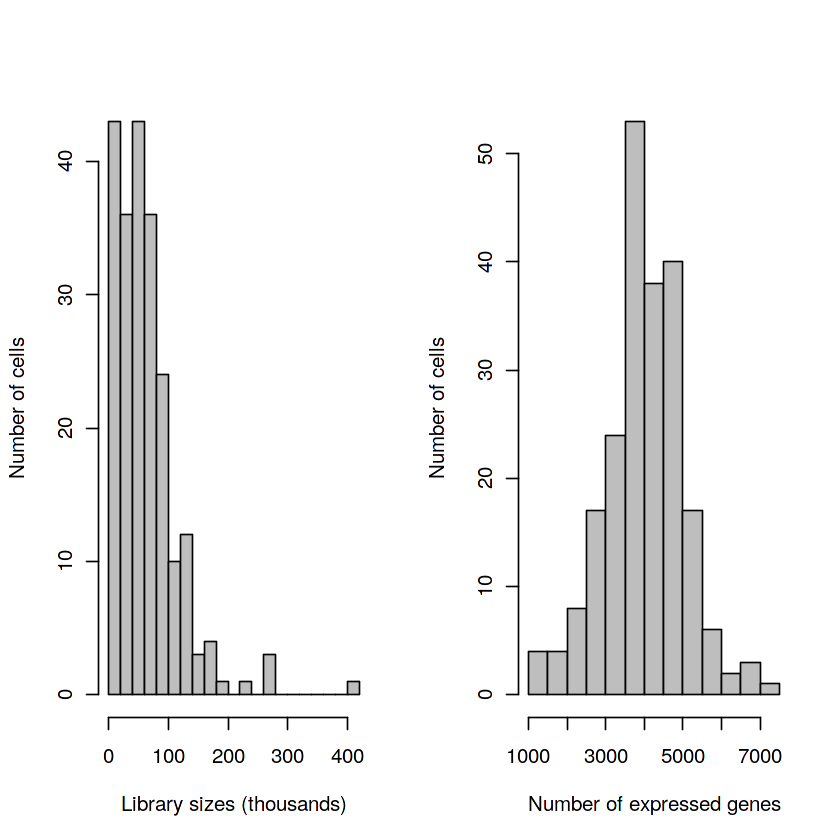

In [19]:
par(mfrow = c(1,2))
hist(sce_mGP$total_counts/1e3, xlab = "Library sizes (thousands)", main = "", breaks = 20,
     col = "grey", ylab = "Number of cells")
hist(sce_mGP$total_features_by_counts, xlab = "Number of expressed genes", main = "", breaks = 20,
     col = "grey", ylab = "Number of cells")

options(repr.plot.width = 8, repr.plot.height = 2)

Selecting a threshold for these metrics is not straightforward as their absolute values depend on the protocol
and the biological system. For example, sequencing to greater depth will lead to more reads, regardless of
the quality of the cells. To obtain an adaptive threshold, we assume that most of the dataset consists of
high-quality cells. We remove cells with log-library sizes that deviate more than 3 absolute deviations from
the median (Lun et al. 2016, Davie et al., 2018). The log transformation is performed to improve resolution
at small values, which is especially necessary when the absolute deviation of the raw values is comparable to
or greater than the median.
Note: Davie et al. only flag a cell as an outlier when its 5 absolute deviations from the median.

In [78]:
libsize.drop <- isOutlier(sce_mGP$total_counts, nmads = 2, type = "both", log = TRUE)
feature.drop <- isOutlier(sce_mGP$total_features_by_counts, nmads = 2, type = "both", log = TRUE)

In [79]:
# libsize.drop cutoff values
(median(sce_mGP$total_counts) + 2*mad(sce_mGP$total_counts))/1e3
(median(sce_mGP$total_counts) - 2*mad(sce_mGP$total_counts))/1e3

# feature.drop cutoff values
median(sce_mGP$total_features_by_counts) + 2*mad(sce_mGP$total_features_by_counts)
median(sce_mGP$total_features_by_counts) - 2*mad(sce_mGP$total_features_by_counts)

[1] 137.2955

[1] -31.3295

[1] 5906.276

[1] 2033.724

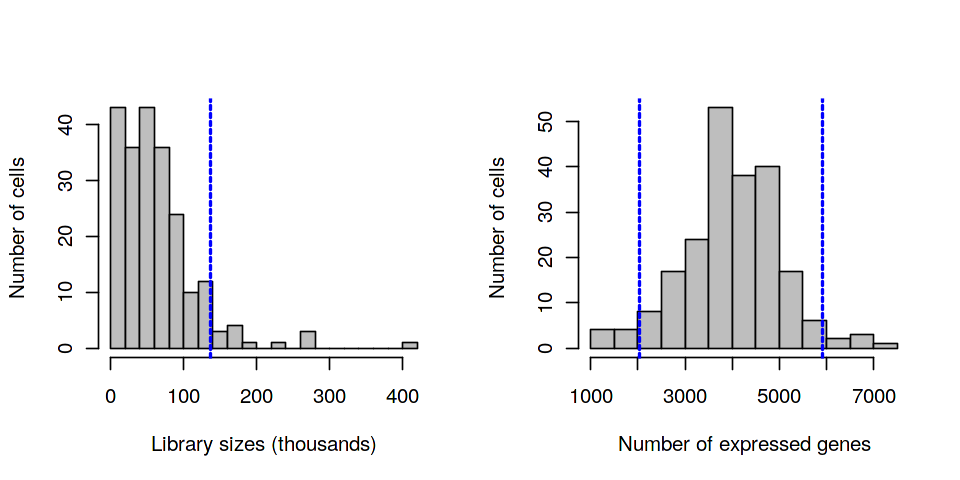

In [80]:
par(mfrow = c(1,2))
hist(sce_mGP$total_counts/1e3, xlab = "Library sizes (thousands)", main = "", breaks = 20,
     col = "grey", ylab = "Number of cells")

abline(v = -31.3294968, col = "blue", lwd = 2, lty = 2)
abline(v = 137.2954968, col = "blue", lwd = 2, lty = 2)

hist(sce_mGP$total_features_by_counts, xlab = "Number of expressed genes", main = "", breaks = 20,
     col = "grey", ylab = "Number of cells")

abline(v = 5906.2756, col = "blue", lwd = 2, lty = 2)
abline(v = 2033.7244, col = "blue", lwd = 2, lty = 2)

Another measure of quality is the proportion of reads mapped to genes in the mitochondrial genome. High
proportions are indicative of poor quality cells (Ilicic et al., 2016), possibly because of increased apoptosis
and/or loss of cytoplasmic RNA from lysed cells. In addition, a high proportion of mitochondrial reads could
reflect an inefficient capture of the RNA when creating the library.
By assuming most cells in the dataset are of high quality, the threshold to remove cells with too high
mitochondrial proportions can be set to remove any large outliers. For this, the median absolute deviation
method is used again.

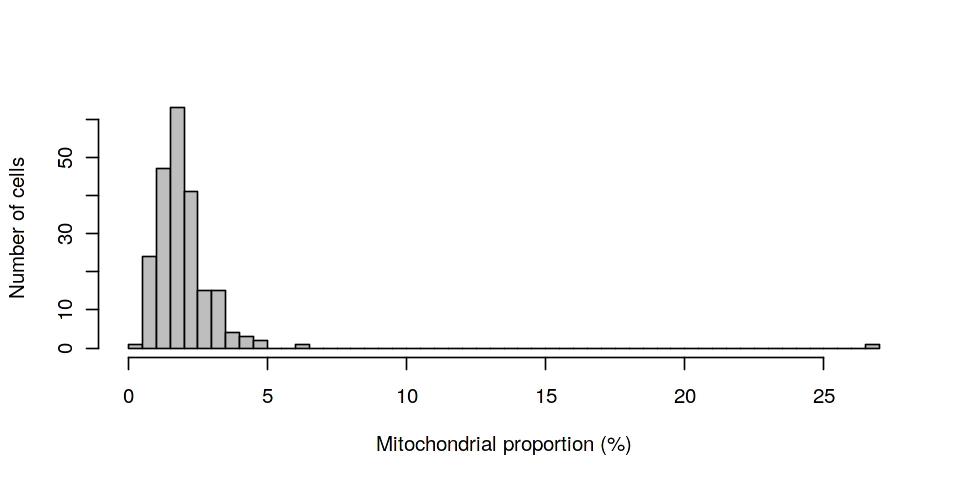

In [81]:
hist(sce_mGP$pct_counts_Mt, xlab = "Mitochondrial proportion (%)",
                            ylab = "Number of cells",
                            breaks = 40, main = "", col = "grey")

In [24]:
mito.drop <- isOutlier(sce_mGP$pct_counts_Mt, nmads = 3, type = "higher")

In [25]:
# mito.drop cutoff value
(median(sce_mGP$pct_counts_Mt) + 3*mad(sce_mGP$pct_counts_Mt))

[1] 3.958399

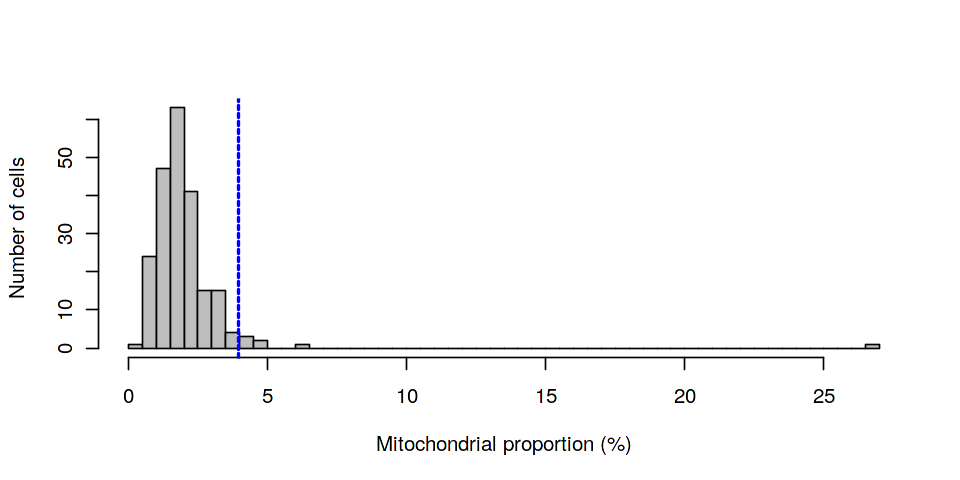

In [49]:
hist(sce_mGP$pct_counts_Mt, xlab = "Mitochondrial proportion (%)",
                            ylab = "Number of cells",
                            breaks = 40, main = "", col = "grey")

abline(v = 3.95839859228968, col = "blue", lwd = 2, lty = 2)

Subset by column to retain only high-quality cells that pass all filters.

In [82]:
sceMP.qc <- sce_mGP[,!(libsize.drop | feature.drop | mito.drop)]
data.frame(ByLibrarySize = sum(libsize.drop), ByFeature = sum(feature.drop), ByMito = sum(mito.drop),
           Remaining = ncol(sceMP.qc))

ByLibrarySize,ByFeature,ByMito,Remaining
19,20,7,186


An alternative approach to perform quality control is to perfom a PCA based on the quality metrics for
each cell, e.g., the total number of reads, the total number of features and the proportion of mitochondrial
reads. Outliers on a PCA plot may be indicative of low-quality cells that have aberrant technical properties
compared to the majority of high-quality cells.

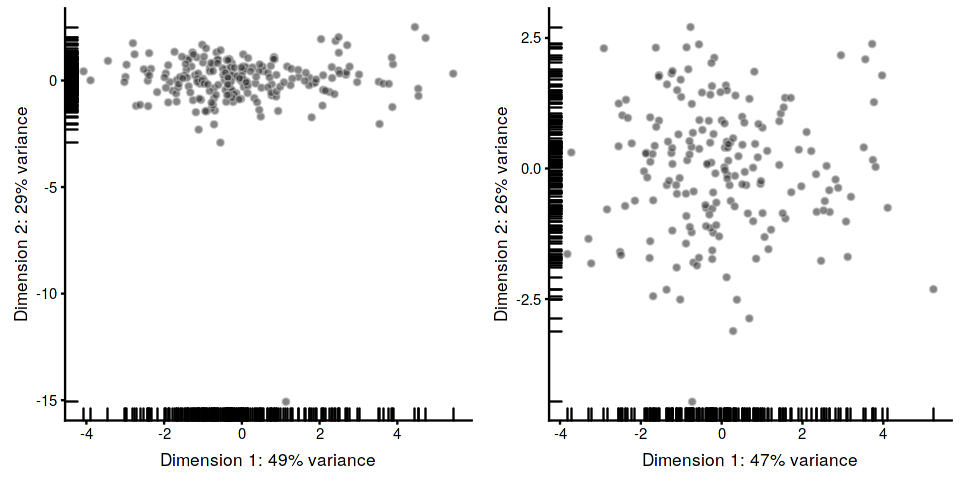

In [83]:
sce_mGP <- runPCA(sce_mGP, use_coldata = TRUE, detect_outliers = TRUE)
sceMP.qc <- runPCA(sceMP.qc, use_coldata = TRUE, detect_outliers = TRUE)

PCA.plot1 <- plotReducedDim(sce_mGP, use_dimred = "PCA_coldata", add_ticks = FALSE) + geom_rug()
PCA.plot2 <- plotReducedDim(sceMP.qc, use_dimred = "PCA_coldata", add_ticks = FALSE) + geom_rug()

plot_grid(PCA.plot1, PCA.plot2)

### Filtering out low-abundance genes

Low-abundance genes are problematic as zero or near-zero counts do not contain enough information for
reliable statsitical inference. Here, low-abundance genes are defined as those with an average count below a
filter threshold of 0.001 (Davie et al., 2018). Removal of these genes mitigates discreteness and reduces the
amount of computational work without major (if any) loss of information.

In [84]:
average.counts <- calculateAverage(sceMP.qc, exprs_values = "counts",
                                   use_size_factors = FALSE, subset_row = NULL)
genes.to.keep <- average.counts >= 0.003
sum(genes.to.keep)

[1] 22893

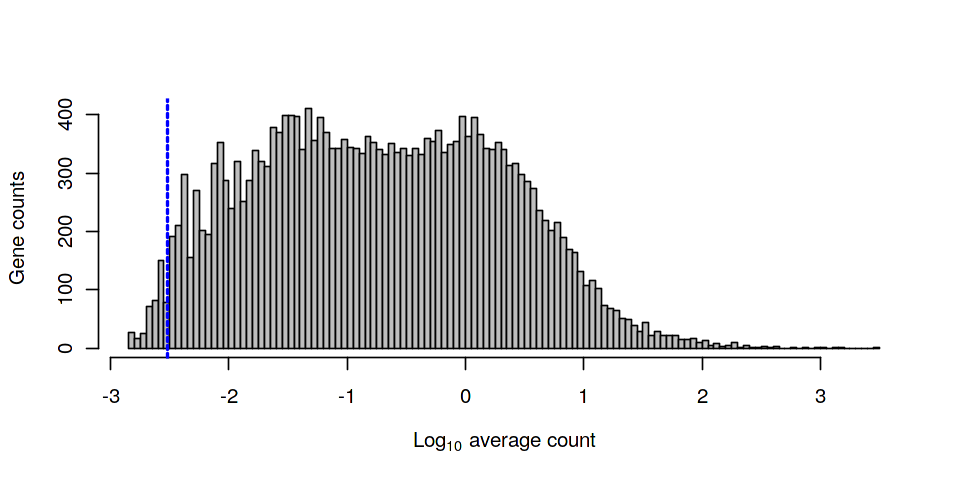

In [85]:
hist(log10(average.counts), breaks = 100, main = "", col = "grey",
     xlab = expression(Log[10]~"average count"), ylab = "Gene counts")
abline(v = log10(0.003), col = "blue", lwd = 2, lty = 2)

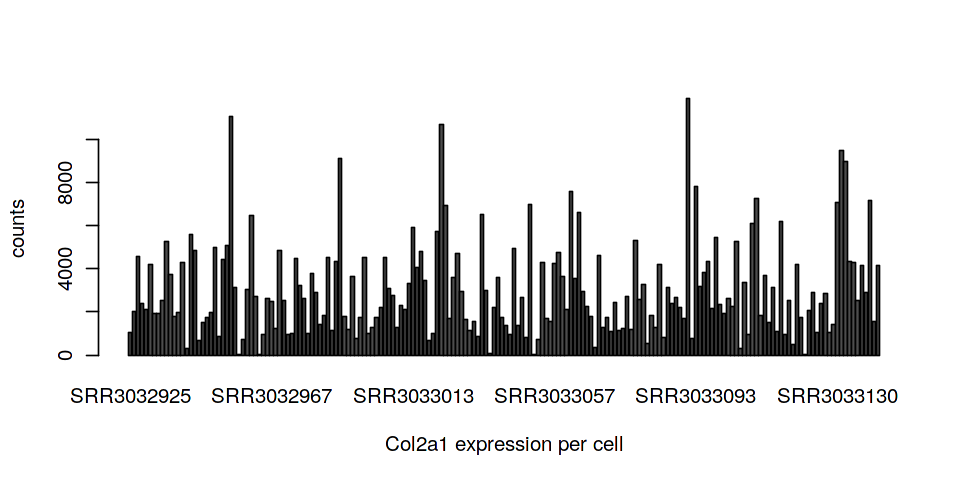

In [92]:
barplot(counts(sceMP.qc['Col2a1',]), xlab = "Col2a1 expression per cell", ylab = "counts")

options(repr.plot.width = 8, repr.plot.height = 2)

The mean-based filter is then applied to the data by subsetting the `SingleCellExperiment` object. This removes all rows corresponding to endogenous genes with abundances below the specified threshold.

In [93]:
sce <- sceMP.qc[genes.to.keep,]
dim(sce)

[1] 22893   186

Dimensions of the filtered and quality-controlled data are **22.787 genes and 203 cells**.

Remove duplicate features:

In [94]:
sce <- sce[!duplicated(rownames(sce)),]
dim(sce)

[1] 22893   186

Lastly, we look at the identities of the most highly expressed genes. This should be dominated by consitutively
expressed transcripts, such as those for ribosomal or mitochondrial proteins. The presence of other classes of
genes may be of concern when not consistent with expected biology. For example, a top set void of ribosomal
proteins and/or their pseudogenes is indicative of suboptimal alignment.

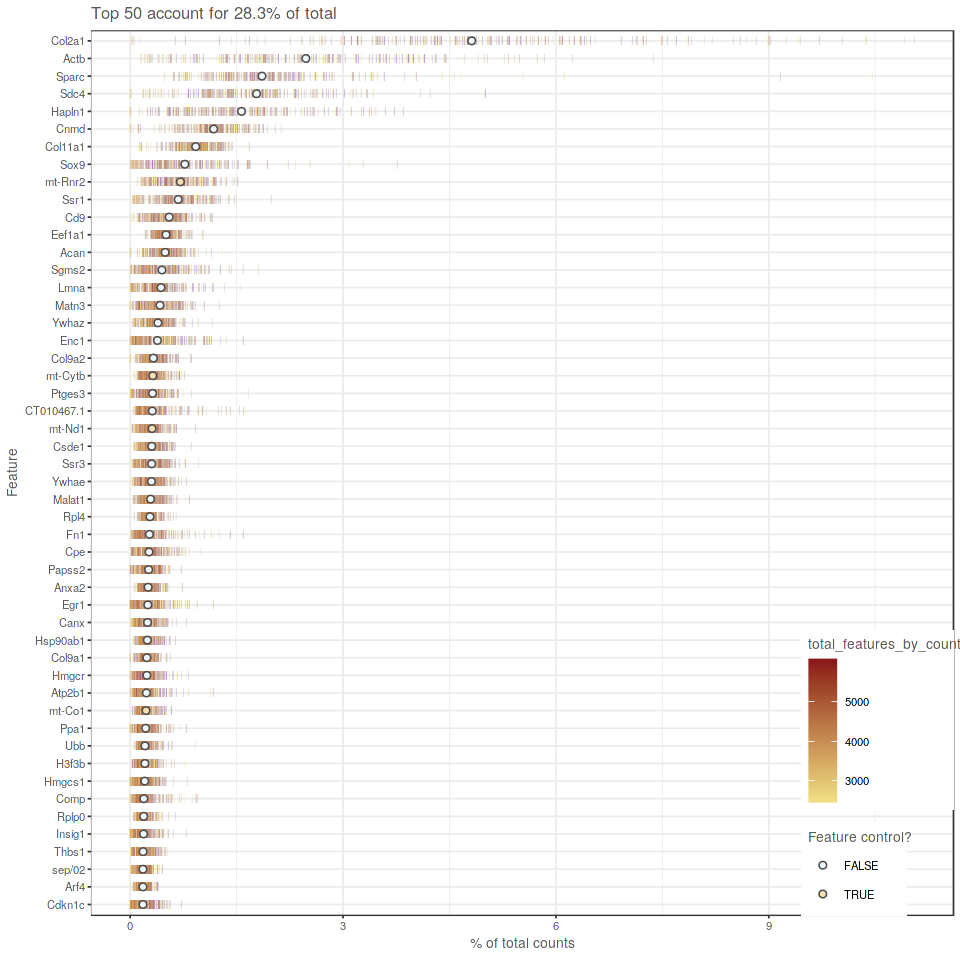

In [96]:
plotHighestExprs(sce, n = 50)
options(repr.plot.width = 8, repr.plot.height = 4)

## Finalization of the dataset

In order to be compatible with Seurat, log-transformed counts (logcounts assay) need to be added to the `SingleCellExperiment` object.

In [97]:
logcounts(sce) <- log2(counts(sce)+1)
names(sce@assays)

[1] "counts"    "logcounts"

In [98]:
saveRDS(sce, file = "mouse.growth.plate_QCfiltered.Rds")